In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor , VotingRegressor , GradientBoostingRegressor ,ExtraTreesRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest , chi2
import pickle

In [222]:
laptop = pd.read_csv('nLAPTOPNEP.csv')

In [223]:
laptop.drop(columns=['Unnamed: 0'] , inplace=True)

In [224]:
laptop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Brand     338 non-null    object
 1   CPU       338 non-null    object
 2   Graphics  338 non-null    object
 3   RAM       338 non-null    object
 4   Display   338 non-null    object
 5   Storage   338 non-null    object
 6   Battery   296 non-null    object
 7   Camera    338 non-null    object
 8   Weight    338 non-null    object
 9   Price     338 non-null    int64 
 10  Type      338 non-null    object
dtypes: int64(1), object(10)
memory usage: 29.2+ KB


# Data Cleaning


## RAM


In [225]:
laptop['RAM(GB)']=laptop['RAM'].apply(lambda x: re.findall('(\d+)\s?[G|g][B|b]' , x)[0]).astype(int)

Text(0.5, 1.0, 'RAM vs Price')

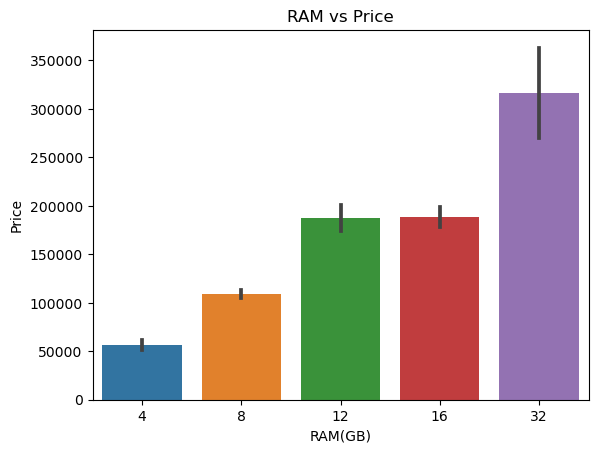

In [226]:
sns.barplot(x=laptop['RAM(GB)'] , y = laptop['Price'])
plt.title('RAM vs Price')

## SSD

In [227]:
laptop['SSD(GB)']=laptop['Storage'].apply(lambda x : re.findall('(\d+)\s?[G|g][B|b]|(\d{3})\s?[SSD]' , x))

In [228]:
#extrct the numeric value from 'Storage'
def filter_value_SSD(x):
    if x == []:
        return None
    elif x[0][0] !='':
        return x[0][0]
    else:
        return x[0][1]
   

In [229]:
laptop['SSD(GB)']=laptop['SSD(GB)'].apply(filter_value_SSD)

In [230]:
laptop['SSD(TB -> GB)']=laptop.loc[laptop['SSD(GB)'].isna(),'Storage'].apply(lambda x : int(re.findall('(\d+)\s?[T|t][B|b]' , x)[0])*1024)

In [231]:
laptop['SSD(GB)'].fillna(laptop['SSD(TB -> GB)'],inplace=True)

In [232]:
laptop.drop(columns=['SSD(TB -> GB)'] , inplace=True)

In [233]:
laptop['SSD(GB)']=laptop['SSD(GB)'].astype(int)

Text(0.5, 1.0, 'Storage(SSD) vs Price')

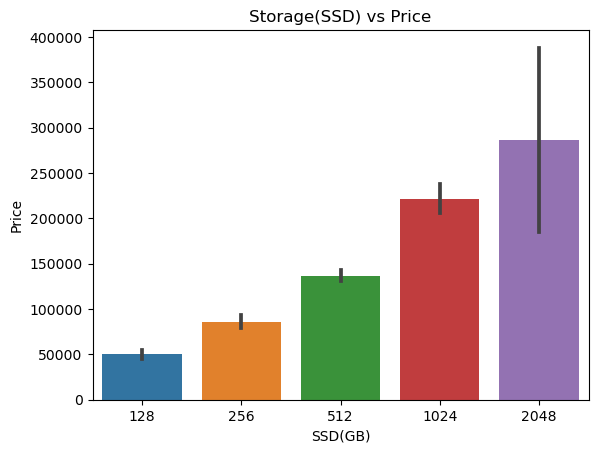

In [234]:
sns.barplot(x=laptop['SSD(GB)'] , y = laptop['Price'])
plt.title('Storage(SSD) vs Price')


## Weight(kg)


In [235]:
laptop['weight_1']=laptop['Weight'].apply(lambda x: re.findall('(\d+\.\d+)\s?[K|k]|(\d+\.\d+)\s?[L|l]' , x))

In [236]:
laptop['weight_1']

0      [(1.85, )]
1      [(1.85, )]
2      [(1.68, )]
3      [(1.85, )]
4              []
          ...    
333    [(, 5.29)]
334    [(, 4.63)]
335    [(, 5.51)]
336    [(, 5.51)]
337    [(, 5.51)]
Name: weight_1, Length: 338, dtype: object

In [237]:
def weight_extraction1(x):
    if x == []:
        return None
    elif x[0][0] != "":
        return float(x[0][0])
    elif x[0][1] != '':
        return float(x[0][1])*0.45359
    else:
        return None

In [238]:
laptop['weight_1'] = laptop['weight_1'].apply(weight_extraction1)

In [239]:
laptop['weight_2'] = laptop.loc[laptop['weight_1'].isna(),'Weight'].apply(lambda x: re.findall('(\d+)\s?[K]|(\d+\.\d+)\s?[g]' , x))

In [240]:
def weight_extraction2(x):
    if x[0][0] != "":
        return float(x[0][0])
    else:
        return float(x[0][1])

In [241]:
laptop['weight_1']

0      1.850000
1      1.850000
2      1.680000
3      1.850000
4           NaN
         ...   
333    2.399491
334    2.100122
335    2.499281
336    2.499281
337    2.499281
Name: weight_1, Length: 338, dtype: float64

In [242]:
laptop['weight_2']=laptop.loc[laptop['weight_1'].isna(),'weight_2'].apply(weight_extraction2)

In [243]:
laptop['Weight(Kg)']=np.nan

In [244]:
 laptop['Weight(Kg)'].fillna(laptop['weight_1'],inplace=True)

In [245]:
laptop['Weight(Kg)'].fillna(laptop['weight_2'],inplace=True)

In [246]:
laptop.drop(columns=['weight_1','weight_2'],inplace=True)

In [247]:
laptop['Weight(Kg)']=laptop['Weight(Kg)'].apply(lambda x : x/10 if x > 10 else x)

Text(0.5, 1.0, 'Plot of Weight(kg) vs Price')

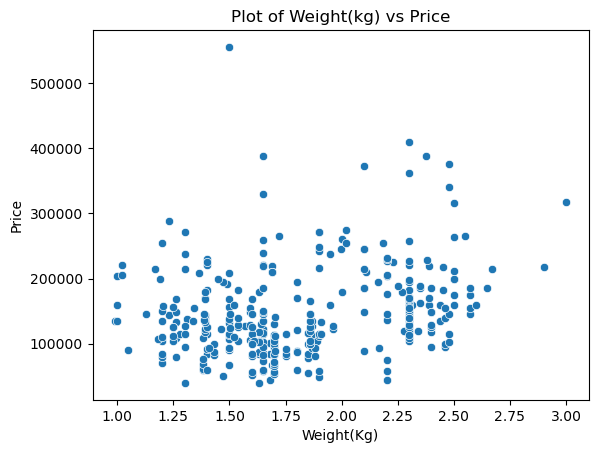

In [248]:
sns.scatterplot(x=laptop['Weight(Kg)'] , y = laptop['Price'])
plt.title('Plot of Weight(kg) vs Price')

In [249]:
laptop[['Weight(Kg)','Price']].corr()

,Weight(Kg),Price
Weight(Kg),1.000000,0.265976
Price,0.265976,1.000000


## Type : Gaming or No Gaming

In [250]:
laptop['Gaming'] =laptop['Type'].str.contains('aming') 

In [251]:
laptop['Gaming']=laptop['Gaming'].apply(lambda x: int(x))

Text(0.5, 1.0, 'Type vs Price')

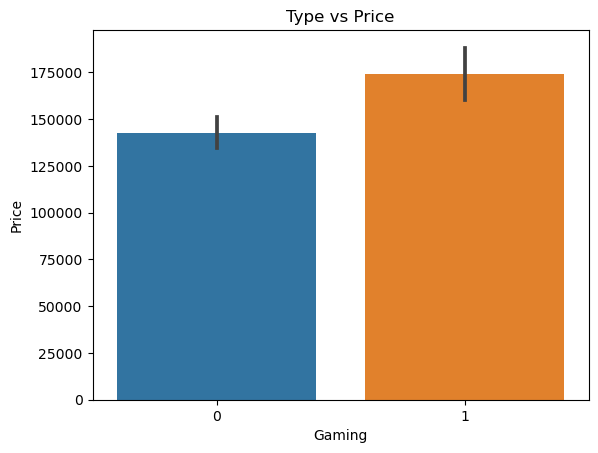

In [252]:
sns.barplot(x=laptop['Gaming'] , y = laptop['Price'])
plt.title('Type vs Price')

## Camera

In [253]:
laptop.loc[laptop['Camera'].str.contains('FHD') , 'Camera'] = '1080p'

In [254]:
laptop.loc[laptop['Camera'].str.contains('HD') , 'Camera'] = '720p'

In [255]:
laptop.loc[laptop['Camera'].str.contains('5') , 'Camera'] = '1080p'

In [256]:
laptop['Camera_'] = laptop['Camera'].apply(lambda x : re.findall('(720)|(1080)' ,x))

In [257]:
def filter_C(x):
    if x ==[]:
        return None
    elif x[0][0] != '':
        return x[0][0]
    else:
        return x[0][1]

In [258]:
laptop['Camera_']=laptop['Camera_'].apply(filter_C)

In [259]:
laptop['Camera_'].fillna('720',inplace=True)

In [260]:
laptop['Camera_']=laptop['Camera_'].astype(int)

Text(0.5, 1.0, 'Camera vs Price')

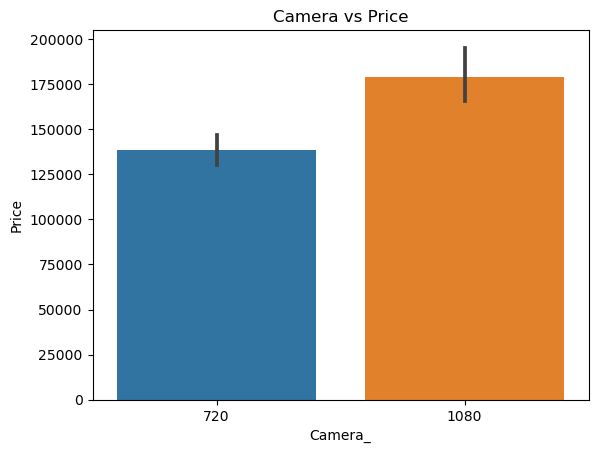

In [261]:
sns.barplot(x=laptop['Camera_'] , y = laptop['Price'])
plt.title('Camera vs Price')

In [262]:
laptop[['Camera_','Price']].corr()

,Camera_,Price
Camera_,1.000000,0.251844
Price,0.251844,1.000000


## Display(PPI)

In [263]:
laptop['dim'] = laptop['Display'].apply(lambda x : re.findall('(\d+\s?[x]\s?\d+)',x))

In [264]:
def pixel_counter(x):
    if x ==[]:
        return float(np.sqrt((1920**2+1080**2)))
    else:
        a,b = x[0].split('x')
        return float(np.sqrt(int(a)**2+int(b)**2))

In [265]:
laptop['dim']=laptop['dim'].apply(pixel_counter)

In [266]:
laptop['inches'] = laptop['Display'].apply(lambda x : float(re.findall('(\d+\.?\d)',x)[0]))

In [267]:
laptop['PPI'] = laptop['dim']/laptop['inches']

In [268]:
laptop['PPI']

0      141.211998
1      141.211998
2      141.211998
3      141.211998
4      141.211998
          ...    
333    141.211998
334    146.860478
335    141.211998
336    188.282664
337    141.509717
Name: PPI, Length: 338, dtype: float64

In [269]:
laptop.drop(columns=['dim','inches'],inplace=True)

In [270]:
#laptop['Graphics'].apply(lambda x : re.findall('(\d+\s?)[G|g]+',x))

## Processor(CPU)

In [271]:
laptop['CPU'] = laptop['CPU'].str.replace('\xa0' , ' ')

In [272]:
laptop['Intel']=np.nan

In [273]:
laptop['Intel']=laptop['CPU'].apply(lambda x : re.findall('Intel(?:®)?(?:\s)?Core(?:™)?(?:\s)?i\d' , x))

In [274]:
def filter_core(x):
    if x==[]:
        return np.nan
    else:
         
        return re.sub('[®,™]' ,'' , x[0])

In [275]:
laptop['Intel']=laptop['Intel'].apply(filter_core)

In [276]:
laptop['AMD']=np.nan

In [277]:
laptop['AMD']=laptop['CPU'].apply(lambda x : re.findall('AMD(?:®)? Ryzen(?:™)? \d' , x))

In [278]:
laptop['AMD']=laptop['AMD'].apply(filter_core)

In [279]:
laptop['Comet Lake'] = np.nan

In [280]:
laptop['Comet Lake']=laptop['CPU'].str.contains('Comet')

In [281]:
laptop['Comet Lake']=laptop['Comet Lake'].apply(lambda x : 'Comet Lake' if x ==True else np.nan )

In [282]:
laptop.loc[laptop['Comet Lake'].isna() & laptop['Intel'].isna() & laptop['AMD'].isna()   , 'CPU']

48         \nIntel Celeron 6305 (2C / 2T, 1.8GHz, 4MB)\n
118    Intel Celeron N4020 Processor 1.1 GHz (4M Cach...
119    Intel Celeron N4020 Processor 1.1 GHz (4M Cach...
224              11th Gen Intel Core I5-1135G7 processor
225                        11th Gen Intel Core I5-1135G7
230              11th Gen Intel Core I7-1165G7 processor
232                        11th Gen Intel Core I7-1165G7
277     Intel Celeron N4020 processor Dual-core 1.10 GHz
283    Intel i3 13th gen Processor Core i3-N305 proce...
284    Intel i3 13th gen Processor Core i3-N305 proce...
293    MD Ryzen 5 5500U hexa-core processor (up to 3 ...
Name: CPU, dtype: object

In [283]:
laptop['Celeron']=laptop['CPU'].str.contains('Celeron')

In [284]:
laptop['Celeron']=laptop['Celeron'].apply(lambda x : 'Intel Celeron ' if x ==True else np.nan )

In [285]:
laptop['Ryzen']=laptop.loc[laptop['Comet Lake'].isna() & laptop['Intel'].isna() & laptop['AMD'].isna()  & laptop['Celeron'].isna()  , 'CPU'].str.contains('Ryzen')

In [286]:
laptop['Ryzen'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 338 entries, 0 to 337
Series name: Ryzen
Non-Null Count  Dtype 
--------------  ----- 
7 non-null      object
dtypes: object(1)
memory usage: 2.8+ KB


In [287]:
laptop['Ryzen']=laptop['Ryzen'].apply(lambda x : 'AMD Ryzen 5' if x == True else np.nan)

In [288]:
laptop['Intel_left']=laptop.loc[laptop['Comet Lake'].isna() & laptop['Intel'].isna() & laptop['AMD'].isna() & laptop['Celeron'].isna() & laptop['Ryzen'].isna(),'CPU']

In [289]:
laptop['Intel_left']=laptop.loc[laptop['Intel_left'].notna(),'Intel_left'].apply(lambda x : 'Intel Core i' + str(re.findall('[i|I](\d)',x)[0]))

In [290]:
laptop.loc[laptop['Intel'].notna(),'Intel']=laptop.loc[laptop['Intel'].notna(),'Intel'].apply(lambda x : 'Intel Core i' + str(re.findall('[i|I](\d)',x)[0])).to_list()

In [291]:
laptop['C.P.U'] = np.nan

In [292]:
laptop['C.P.U'].fillna(laptop['Intel'],inplace=True)

In [293]:
laptop['C.P.U'].fillna(laptop['Intel_left'],inplace=True)

In [294]:
laptop['C.P.U'].fillna(laptop['Ryzen'],inplace=True)

In [295]:
laptop['C.P.U'].fillna(laptop['Comet Lake'],inplace=True)

In [296]:
laptop['C.P.U'].fillna(laptop['Celeron'],inplace=True)

In [297]:
laptop['C.P.U'].fillna(laptop['AMD'],inplace=True)

Text(0.5, 1.0, 'Processor(CPU) vs Price')

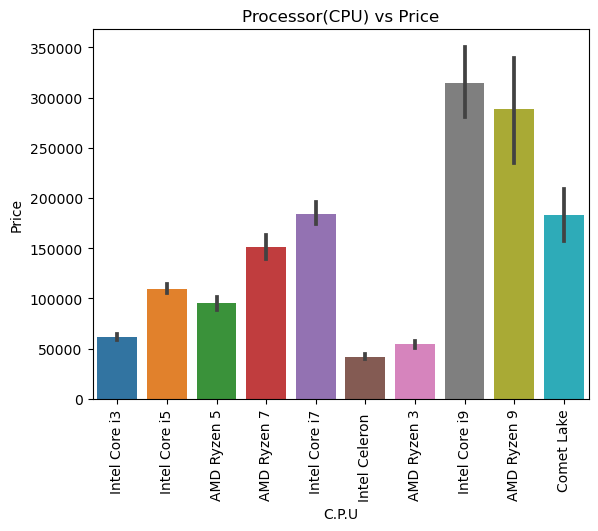

In [298]:
sns.barplot(x=laptop['C.P.U'] , y = laptop['Price'])
plt.xticks(rotation=90)
plt.title('Processor(CPU) vs Price')

In [299]:
laptop.drop(columns=['Intel','AMD','Comet Lake','Celeron','Ryzen','Intel_left'] , inplace  =True)

## Graphics

In [300]:
laptop['Graphics']=laptop['Graphics'].str.replace('\xa0' , ' ')

In [301]:
laptop['Graphics']=laptop['Graphics'].str.replace('\n' , '')

In [302]:
laptop['intel_grap']=laptop.loc[laptop['Graphics'].str.contains('Intel') , 'Graphics']

In [303]:
laptop.loc[laptop['intel_grap'].notna() & laptop['intel_grap'].str.contains('Iris') ,'intel_grap'] = 'Intel Iris Xe'

In [304]:
laptop.loc[laptop['intel_grap'].notna() &  ~laptop['intel_grap'].str.contains('Iris',na=False) ,'intel_grap'] = 'Intel UHD'

In [305]:
laptop['NVIDIA']=laptop.loc[laptop['Graphics'].str.contains('GeForce|NVIDIA|Nvidia|NVIDA|Geforce') , 'Graphics']

In [306]:
def NVIDIA(x):
    a =re.findall('([\d+[0]\d+[0])',x)
    if a == []:
        return 'NVIDIA GeForce'
    elif a[0] in ['3050','3060','1650']:
        return  'NVIDIA GeForce' #'NVIDA GeForce'+ ' ' f'{a[0]}'
    else:
        return 'NVIDIA GeForce'

In [307]:
laptop.loc[laptop['NVIDIA'].notna(),'NVIDIA'] = laptop.loc[laptop['NVIDIA'].notna(),'NVIDIA'].apply(NVIDIA)

In [308]:
laptop['AMD_G']=laptop.loc[laptop['Graphics'].str.contains('AMD|Radeon') , 'Graphics']

In [309]:
laptop.loc[laptop['AMD_G'].notna(),'AMD_G'] = 'AMD Radeon'

In [310]:
laptop['Graphics_Processor'] = np.nan

In [311]:
laptop['Graphics_Processor'].fillna(laptop['intel_grap'],inplace=True)

In [312]:
laptop['Graphics_Processor'].fillna(laptop['NVIDIA'],inplace=True)

In [313]:
laptop['Graphics_Processor'].fillna(laptop['AMD_G'],inplace=True)

Text(0.5, 1.0, 'Graphics vs Price')

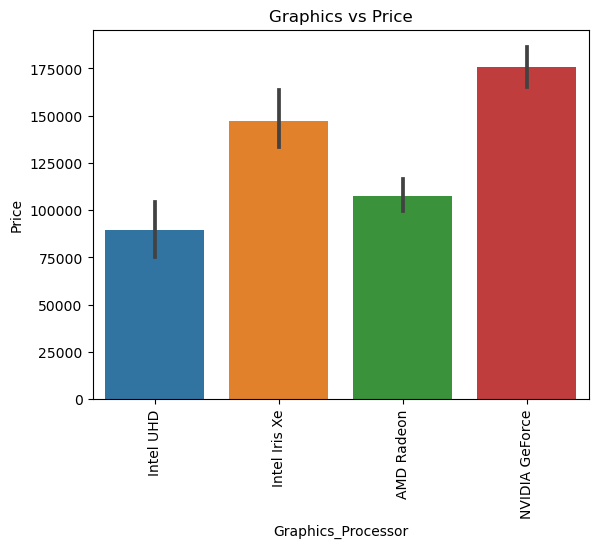

In [314]:
sns.barplot(x=laptop['Graphics_Processor'] , y = laptop['Price'])
plt.xticks(rotation=90)
plt.title('Graphics vs Price')

In [315]:
laptop.drop(columns=['CPU' , 'Graphics' , 'RAM' , 'Display' , 'Storage' ,'Battery' , 'Camera' , 'Weight','intel_grap','AMD_G','NVIDIA','Type'],inplace=True)

# Feature

In [316]:
laptop

,Brand,Price,RAM(GB),SSD(GB),Weight(Kg),Gaming,Camera_,PPI,C.P.U,Graphics_Processor
0,Dell,55000,4,128,1.850000,0,720,141.211998,Intel Core i3,Intel UHD
1,Dell,78000,8,512,1.850000,0,720,141.211998,Intel Core i5,Intel Iris Xe
2,Dell,84300,8,512,1.680000,0,720,141.211998,AMD Ryzen 5,AMD Radeon
3,Dell,85000,8,512,1.850000,0,720,141.211998,Intel Core i5,NVIDIA GeForce
4,Dell,85000,8,256,1.600000,0,720,141.211998,AMD Ryzen 5,AMD Radeon
...,...,...,...,...,...,...,...,...,...,...
333,Acer,185000,8,1024,2.399491,1,720,141.211998,AMD Ryzen 7,NVIDIA GeForce
334,Acer,185000,16,512,2.100122,0,720,146.860478,Intel Core i7,NVIDIA GeForce
335,Acer,199000,16,1024,2.499281,0,720,141.211998,Intel Core i7,NVIDIA GeForce
336,Acer,199000,16,1024,2.499281,1,720,188.282664,Intel Core i7,NVIDIA GeForce


C:\Users\HOME PC\AppData\Local\Temp\ipykernel_16320\2924124806.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(laptop['Price'])


Text(0.5, 1.0, 'Price distribution')

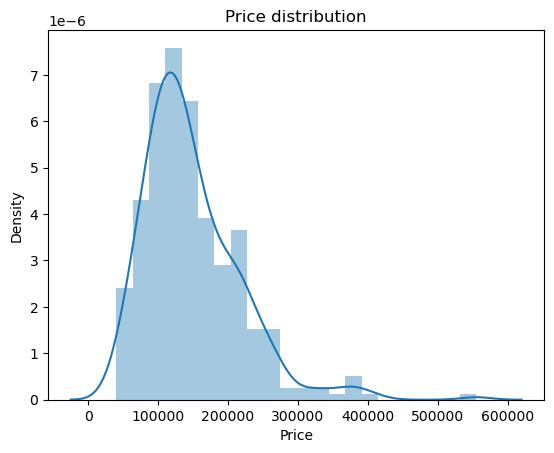

In [328]:
sns.distplot(laptop['Price'])
plt.title('Price distribution')

In [329]:
laptop['RAM(GB)'] = laptop['RAM(GB)'].astype(int)

### Shuffling Data 

In [330]:
laptop =laptop.sample(frac=1).reset_index(drop=True)

### Price Value 

In [331]:
Y = laptop['Price']

In [332]:
laptop.columns

Index(['Brand', 'Price', 'RAM(GB)', 'SSD(GB)', 'Weight(Kg)', 'Gaming',
       'Camera_', 'PPI', 'C.P.U', 'Graphics_Processor'],
      dtype='object')

In [333]:
X =laptop[['Brand', 'RAM(GB)', 'SSD(GB)', 'C.P.U','Weight(Kg)','Graphics_Processor','PPI']]

### Encoding Data using Column Transsformer

In [334]:
transformer = ColumnTransformer(transformers=[
    ('trans' , OneHotEncoder(sparse=False , drop='first'),['Brand','C.P.U','Graphics_Processor'])
] , remainder='passthrough')

In [335]:
X_train , X_test , y_train ,y_test = train_test_split(X , Y ,train_size=0.92 , random_state=101)

In [336]:
transformer_1 = SelectKBest(score_func=chi2, k=5)

### Random forest

In [337]:
transformer_2 = RandomForestRegressor(n_estimators=140,min_samples_split=40,max_features=1,criterion='squared_error')
pipe_1 = Pipeline([('tr0' ,transformer),('tr1',transformer_1), ('tr2' , transformer_2)] )
pipe_1.fit(X_train,y_train)
y_pred = pipe_1.predict(X_test)
print('R2 score :' + f'{r2_score(y_test,y_pred)}')

R2 score :0.7786540179413386


C:\ProgramData\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


### Voting Regressor

In [338]:
rf   = RandomForestRegressor(n_estimators=140,min_samples_split=35,max_features=1,criterion='friedman_mse')
gb   = GradientBoostingRegressor(n_estimators=150,min_samples_split=45,max_features=2)
etr  = ExtraTreesRegressor(n_estimators=150,min_samples_split=50,max_features=3)

transformer_3 = VotingRegressor([('rf',rf),('gb',gb),('etr',etr)] , weights=[1,3,5])
pipe_2 =Pipeline([('tr0' ,transformer),('tr1',transformer_1), ('tr3' , transformer_3)] )
pipe_2.fit(X_train,y_train)
y_pred = pipe_2.predict(X_test)
print('R2 score :' + f'{r2_score(y_test,y_pred)}')

C:\ProgramData\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:828: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


R2 score :0.7953804734660955


In [339]:
pickle.dump(laptop,open('laptop.pkl','wb'))

In [341]:
pickle.dump(pipe_2,open('laptop.pkl','wb'))